In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from numba import jit, njit
from numba.types import float64, int64
from general_functions import *

In [12]:
def initiate_values():
    if len(sys.argv) != 5:
        N, S, M = 2, 3, 6
        lambd = 0.01 # small-but-not-too-small
    else:
        N = int(sys.argv[1])
        S = int(sys.argv[2])
        M = int(sys.argv[3])
        lambd = float(sys.argv[4])

    return N, S, M, lambd

@njit
def rand_choice_numba(prob):
    return np.searchsorted(np.cumsum(prob), np.random.random(), side="right")

@jit(float64[:](float64[:], int64, float64[:]),nopython=True)
def round_numba(x, decimals, out):
    return np.round_(x, decimals, out)

@njit
def equilibrium_numba(phi, M, N, threshold=0.99):

    # eq reached if the M x N highest values are all above the threshold

    phi = phi.ravel() # convert to 1D
    sorted_index_arr = np.argsort(phi)
    sorted_phi = phi[sorted_index_arr]
    highest_vals = sorted_phi[-(M * N):]

    all_above_thresh = True
    for val in highest_vals:
        if val < threshold: all_above_thresh = False

    return all_above_thresh # equilibrium if all above the threshold

@njit
def get_sm_distribution_numba(N, S, M, lambd, max_steps=5000000):

    phi = np.ones((N, S, M)) / S # phi = 1/S for all speakers

    for i in range(max_steps):

        intend = np.random.randint(M) # meaning intended -- rho = 1/M, uniform distribution
        speaker = np.random.randint(N)
        listener = np.random.randint(N)
        while listener == speaker: listener = np.random.randint(N)

        produce = rand_choice_numba(prob = phi[speaker,:,intend])
        infer = rand_choice_numba(prob = phi[listener,produce,:] / np.sum(phi[listener,produce,:]))
        # updating phi
        feedback = lambd if infer == intend else - lambd
        phi[speaker,produce,intend] += (feedback * phi[speaker,produce,intend] * (1 - phi[speaker,produce,intend]))
        phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend]) # normalise along signal axis

        if i % 5000 == 0 and i > 0:

            if equilibrium_numba(phi, M, N): 
                # twice as many meanings as there are signals
                # sum elements on meaning axis (axis=1) to see how many signals are associated with each meaning
                # print('equilibrium reached')
                x = phi[0,:,:].ravel()
                rounded_array = round_numba(x, 0, np.empty_like(x))
                rounded_array = np.copy(rounded_array).reshape((S,M))
                sm_distr = rounded_array.sum(axis=1).astype(np.int64) # signal-meaning distribution
                sm_distr = np.sort(sm_distr) # only interested in the repartition of meanings, not the order

                return sm_distr

        if i == max_steps - 1: return None

def factorial(n):
    return 1 if (n==1 or n==0) else n * factorial(n - 1)

def multiplicity(key_str):

    k_list = [int(x) for x in key_str]
    S = len(k_list)
    M = sum(k_list)
    k_set = list(set(k_list))
    denom1 = 1
    for k in k_list: denom1 *= factorial(k)
    denom2 = 1
    for k_ in k_set:
        n_k = k_list.count(k_)
        denom2 *= factorial(n_k) # if any blocks of same length, take factorial

        # i don't really understand why this step is required (taking it out produces worse results)

    # total number of possible arrangements S**M (S choices for the M meanings)

    return S**(-M) * factorial(M) / denom1 * factorial(S) / denom2

def get_multiplicities(keys_list):

    multiplicities = []
    for key in keys_list:
        multiplicities.append(multiplicity(key))
    
    return np.array(multiplicities)

run the simulation and the MC method

the dictionaries are stored as variables and accessed in the cell below for plotting

In [13]:
N, S, M, lambd, n_MC, n_trials = 2, 8, 8, 0.1, 100000, 100

dic_MC = {}

for i in range(n_MC):

    arr = np.zeros((S,M))
    for meaning in range(M):
        signal = np.random.randint(S) # one signal per meaning
        arr[signal, meaning] = 1

    sm_distr = arr.sum(axis=1).astype(int)
    sm_distr = np.sort(sm_distr)
    string = ''.join(str(x) for x in sm_distr)

    if string in dic_MC:
        dic_MC[string] += 1
    else:
        dic_MC[string] = 1

dic_sim = {}

for i in range(n_trials):
    
    sm_distr = get_sm_distribution_numba(N, S, M, lambd)
    if sm_distr is None: 
        print(f'trial {i}: no equilibrium reached')
        continue
    # ensure not None (no equilibrium reached)
    string = ''.join(str(x) for x in sm_distr)
    print(f'trial {i}: ' + string)
    if string in dic_sim:
        dic_sim[string] += 1
    else:
        dic_sim[string] = 1

trial 0: no equilibrium reached
trial 1: no equilibrium reached
trial 2: no equilibrium reached
trial 3: 11111111
trial 4: 11111111
trial 5: no equilibrium reached
trial 6: no equilibrium reached
trial 7: 11111111
trial 8: no equilibrium reached
trial 9: 11111111
trial 10: 11111111
trial 11: no equilibrium reached
trial 12: 11111111
trial 13: no equilibrium reached
trial 14: no equilibrium reached
trial 15: no equilibrium reached
trial 16: no equilibrium reached
trial 17: no equilibrium reached
trial 18: no equilibrium reached
trial 19: no equilibrium reached
trial 20: 11111111
trial 21: no equilibrium reached
trial 22: no equilibrium reached
trial 23: 11111111
trial 24: no equilibrium reached
trial 25: no equilibrium reached
trial 26: no equilibrium reached
trial 27: no equilibrium reached
trial 28: no equilibrium reached
trial 29: 11111111
trial 30: no equilibrium reached
trial 31: 11111111
trial 32: 11111111
trial 33: 11111111
trial 34: no equilibrium reached
trial 35: no equilibriu

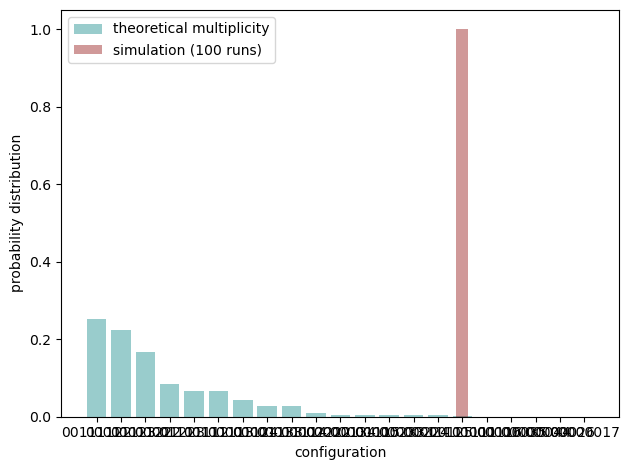

In [14]:
fig, ax = plt.subplots(tight_layout=True)

x_MC, y_MC = np.array(list(dic_MC.keys())), np.array(list(dic_MC.values()))
y_MC = y_MC / y_MC.sum() # normalised
inds = np.argsort(-y_MC)

mult = get_multiplicities(list(dic_MC.keys()))

x_sim, y_sim = np.array(list(dic_sim.keys())), np.array(list(dic_sim.values()))
y_sim = y_sim / y_sim.sum()

# ax.bar(x_MC[inds], y_MC[inds], color='teal', alpha=0.5, label='Monte Carlo simulation', width=0.8)
ax.bar(x_MC[inds], mult[inds], color='teal', alpha=0.4, label='theoretical multiplicity', width=0.8)
ax.bar(x_sim, y_sim, color='darkred', alpha=0.4, label=f'simulation ({n_trials} runs)', width=0.5)
# ax.set_title(f'$(N, S, M, \lambda) = ({N}, {S}, {M}, {lambd})$')
ax.set_xlabel('configuration')
ax.set_ylabel('probability distribution')
ax.legend()

fig.savefig('/Users/casimirfisch/Desktop/Uni/MPhys/code/plots/multiplicity/'+f'mult{N}.{S}.{M}.{lambd}.png', dpi=400)
plt.show()

In [27]:
_222 = np.array([[[1, 1, 0, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0],
                  [0, 0, 0, 0, 1, 1]],
                 [[1, 1, 0, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0],
                  [0, 0, 0, 0, 1, 1]],
                  [[1, 1, 0, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0],
                  [0, 0, 0, 0, 1, 1]]])

print(intelligibility(_222, N=3, S=3, M=6)) # 1/2

_123 = np.array([[[1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0],
                  [0, 1, 0, 0, 1, 1]],
                 [[1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0],
                  [0, 1, 0, 0, 1, 1]],
                  [[1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0],
                  [0, 1, 0, 0, 1, 1]]])

print(intelligibility(_123, N=3, S=3, M=6)) # 1/2

_024 = np.array([[[1e-20, 0, 0, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0],
                  [1-1e-20, 1, 0, 0, 1, 1]],
                 [[1e-20, 0, 0, 0, 0, 0],
                  [0, 0, 1, 1, 0, 0],
                  [1-1e-20, 1, 0, 0, 1, 1]]])

print(intelligibility(_024, N=2, S=3, M=6)) # 1/3

_114 = np.array([[[1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 1, 0, 1, 1, 1]],
                 [[1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 1, 0, 1, 1, 1]]])

print(intelligibility(_114, N=2, S=3, M=6)) # 1/2

_006 = np.array([[[1e-20, 0, 0, 0, 0, 0],
                  [1e-20, 0, 0, 0, 0, 0],
                  [1-2e-20, 1, 1, 1, 1, 1]],
                 [[1e-20, 0, 0, 0, 0, 0],
                  [1e-20, 0, 0, 0, 0, 0],
                  [1-2e-20, 1, 1, 1, 1, 1]]])

print(intelligibility(_006, N=2, S=3, M=6)) # 1/6

0.5
0.5000000000000001
0.3333333333333333
0.5
0.16666666666666666


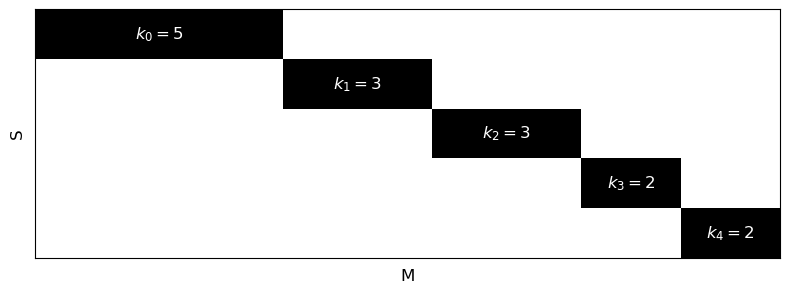

In [27]:
S, M = 5, 15
grid = np.zeros((S,M))
grid[0,0:5] = 1
grid[1,5:8] = 1
grid[2,8:11] = 1
grid[3,11:13] = 1
grid[4,13:] = 1

fig, ax = plt.subplots(figsize=(8,3), tight_layout=True)
ax.imshow(grid, cmap='binary')
ax.set_xlabel('M', fontsize=12)
ax.set_ylabel('S', fontsize=12)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])
ax.grid(visible=True)

for s in range(S):
    x, y = np.mean(np.arange(M)[grid[s]==1]), s
    ax.text(x, y, f'$k_{s} = {int(np.sum(grid[s]))}$', color='w', ha='center', va='center', fontsize=12)

fig.savefig('/Users/casimirfisch/Desktop/Uni/MPhys/code/plots/multiplicity/'+'figure.png', dpi=400)